## Evaluation of Bayes model compared to simple average
- Do Bayes across datasets with the integration weights calculated from Full Variance Decomposition
- Comparing with dataset mean method
- Evaluation done with leave-one-dataset-out (LODO)

This notebook uses some datasets and compares the performance of 2 models.
- `loo`: The leave-one-subject-out model which simply averages the connectivity weights
- `bayes`: Uses the leave-one-subject-out manner but do weighted average across subjects accroding to their `coef_var`


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
from statannotations.Annotator import Annotator
import Functional_Fusion.dataset as fdata
import glob
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

In [9]:
def heatmap_annotate(df_to_plot, ds_order, ax, column=['train_dataset'], row=['eval_dataset'], value=['R_eval'], cmap='inferno', vmin=0, vmax=0.5):
    ds_order_y = [ds for ds in ds_order if 'Fusion' not in ds]
    V = pd.pivot_table(df_to_plot, columns=column, index=row, values=value)
    V = V.reindex(ds_order_y, axis=0)
    V = V.reindex(ds_order, level=1, axis=1)

    sns.heatmap(V.values, annot=True, fmt=".2f", cmap=cmap, vmin=vmin, vmax=vmax, 
                xticklabels=V.columns.get_level_values(1).values, 
                yticklabels=V.index.values, square=True, ax=ax)
    
    if len(ds_order_y) != len(ds_order):
        ax.axvline(len(ds_order_y), color='k', linewidth=2)

    return ax

### Bayes using half estimation

In [10]:
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
df_all = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = []
    for eval_ds in dataset_list:
        if eval_ds!=dataset_name:
            if (eval_ds!='Fus') & (eval_ds!='Language'):
                eval_data.append(eval_ds)
            elif eval_ds=='Language':
                eval_data.append('Languagelocalizer_cond')

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg"],methods=['L2reghalf'],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df])

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo"],methods=['L2reghalf'],eval_data=[dataset_name if dataset_name!='Language' else 'Languagelocalizer_cond'],cerebellum='MNISymC3')
    df['model'] = dataset_name+"-loo"
    df_all = pd.concat([df_all, df])

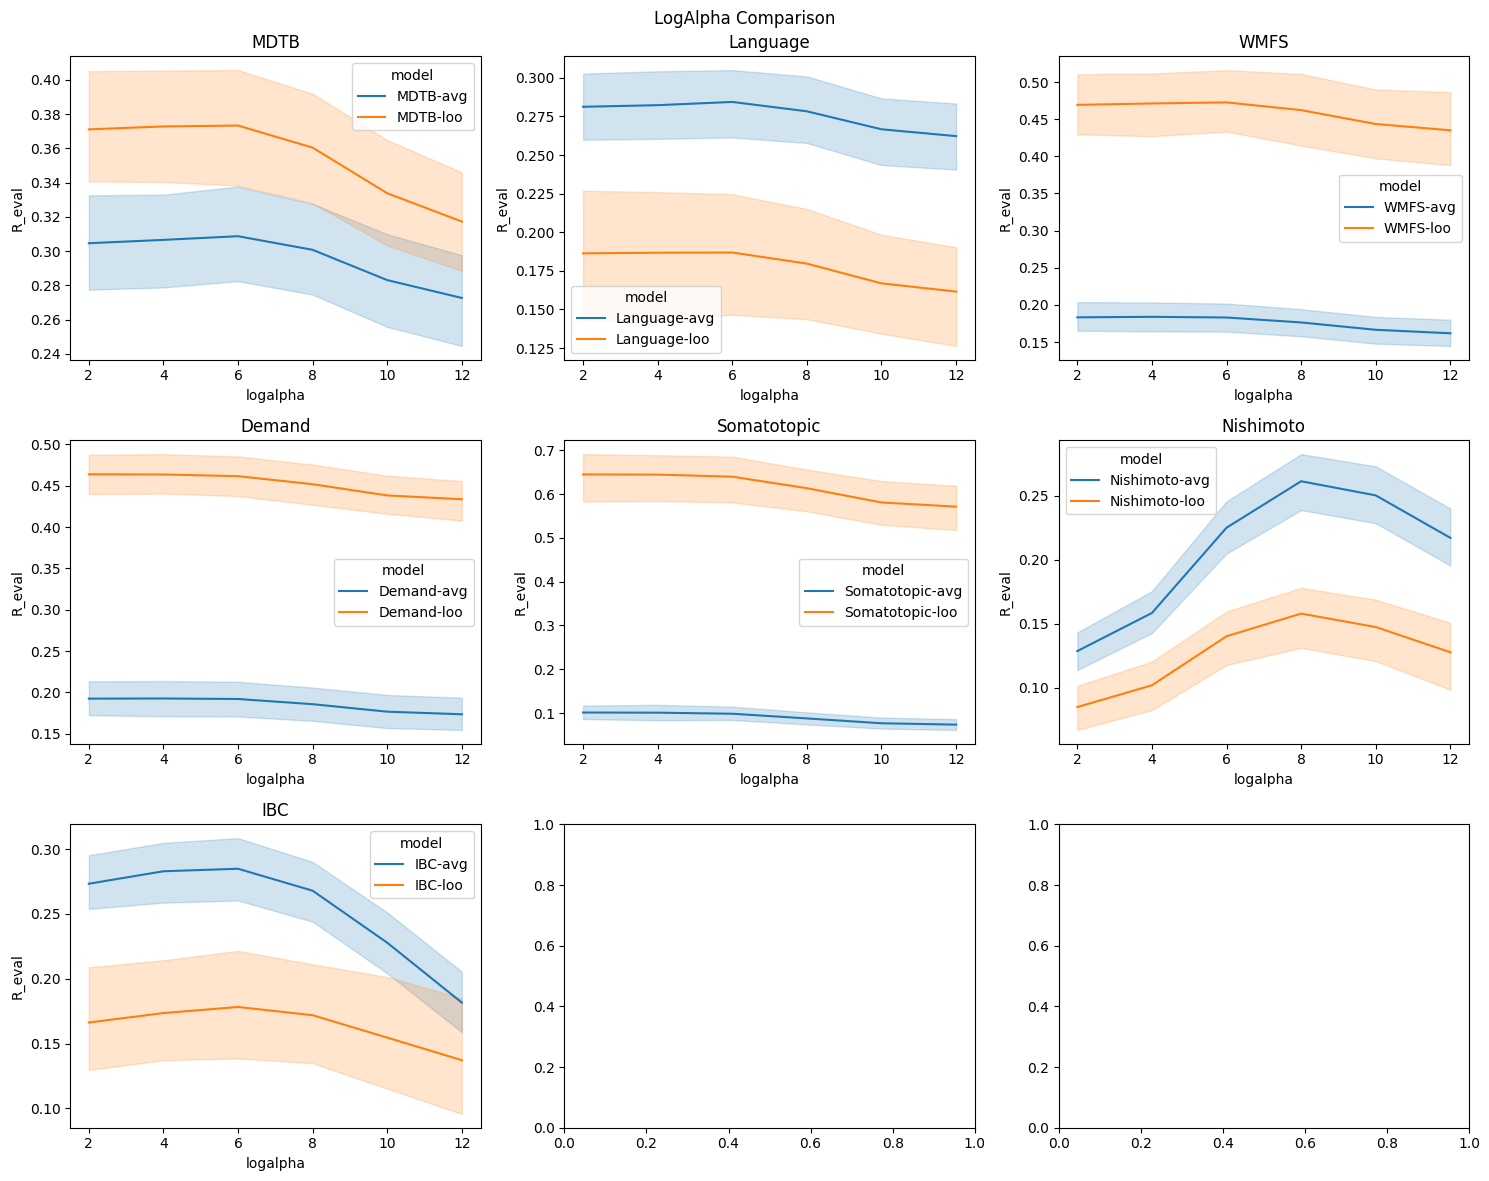

In [11]:
plt.subplots(int(np.ceil(len(dataset_list)/3)),3,figsize=(15,int(np.ceil(len(dataset_list)/3))*4))
plt.suptitle('LogAlpha Comparison')
for d,dataset in enumerate(dataset_list):
    plt.subplot(int(np.ceil(len(dataset_list)/3)),3,d+1)
    df_to_eval = df_all[df_all['train_dataset'] == dataset]
    sns.lineplot(data=df_to_eval, y='R_eval', x='logalpha', hue='model', palette="tab10")
    plt.title(dataset)
plt.tight_layout()

In [12]:
A = pd.pivot_table(df_all,index=['train_dataset'],columns=['logalpha'],values=['R_eval']).reindex(dataset_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_all['isbest'] = (df_all.logalpha.values == bestla.loc[df_all.train_dataset].values.flatten()) | (df_all.train_dataset.str.contains('Fus'))

R_eval                                                  
logalpha           2.0       4.0       6.0       8.0       10.0      12.0
train_dataset                                                            
MDTB           0.317886  0.319790  0.321613  0.312669  0.293186  0.281544
Language       0.267831  0.268780  0.270601  0.264377  0.252568  0.248014
WMFS           0.221470  0.222306  0.221710  0.214559  0.203505  0.198305
Demand         0.276154  0.276192  0.275150  0.267818  0.257370  0.253774
Somatotopic    0.137500  0.137178  0.134586  0.122857  0.110326  0.106842
Nishimoto      0.126576  0.155703  0.220900  0.256246  0.245240  0.212745
IBC            0.262598  0.271973  0.274183  0.258311  0.220490  0.177164

,best_logalpha
train_dataset,
MDTB,6.0
Language,6.0
WMFS,4.0
Demand,4.0
Somatotopic,2.0
Nishimoto,8.0
IBC,6.0


### Bayesian Integration
Assuming that true connectivity weights are:
$$ W_i = W_u + W_d + W_{s_i} $$
our measurements are:
$$ \hat{W_i} = sc_i (W_u + W_d + W_{s_i} + \epsilon_i) $$
thus, the variance of the measurements are (assuming independence):
$$ Var(\hat{W_i}) = sc_i^2 (V_u + V_d + V_s + V_{m_i}) $$

first, we should un-scale the measurements to obtain same level of signal:
$$ W_n = \frac{\hat{W_i}}{sc_i} $$
$$ Var(W_n) = V_u + V_d + V_s + V_{m_i} $$

then, integrate using the noise variance:
$$ \sum \frac{1}{V_d + V_s + V_{m_i}} W_n $$

where the effective integration weights are:
$$ \sum \frac{1}{sc_i (V_d + V_s + V_{m_i})} \hat{W_i} $$

In [15]:
# Load avg fusion
df_fuse_avg = rm.comb_eval(models=["Fus-lodo-avg"],methods=['L2reghalf'],eval_data=["all"],cerebellum='MNISymC3')
df_fuse_avg['train_dataset'] = 'Fusion-avg'

# Load bayes fusion
df_fuse_bayes = rm.comb_eval(models=["Fus-lodo-bayes"],methods=['L2reghalf'],eval_data=["all"],cerebellum='MNISymC3')
df_fuse_bayes['train_dataset'] = 'Fusion-bayes'

# Load the region fusion
df_fuse_voxel = rm.comb_eval(models=["Fus-lodo-voxel"],methods=['L2reghalf'],eval_data=["all"],cerebellum='MNISymC3')
df_fuse_voxel['train_dataset'] = 'Fusion-voxel'

df_best = df_all[df_all['isbest']].copy()

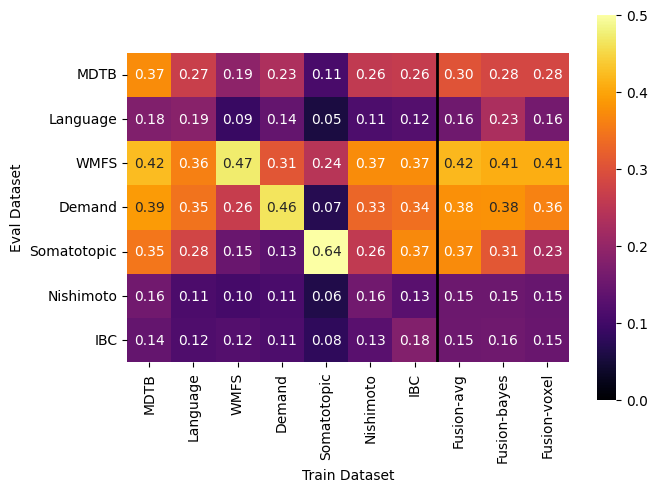

In [16]:
plt.figure(figsize=(7, 5))
ds_order = dataset_list + ['Fusion-avg', 'Fusion-bayes', 'Fusion-voxel']
df_to_plot = pd.concat([df_best, df_fuse_avg, df_fuse_bayes, df_fuse_voxel])
ax = heatmap_annotate(df_to_plot, ds_order, ax=plt.gca())
ax.set_xlabel('Train Dataset')
ax.set_ylabel('Eval Dataset')
plt.tight_layout()

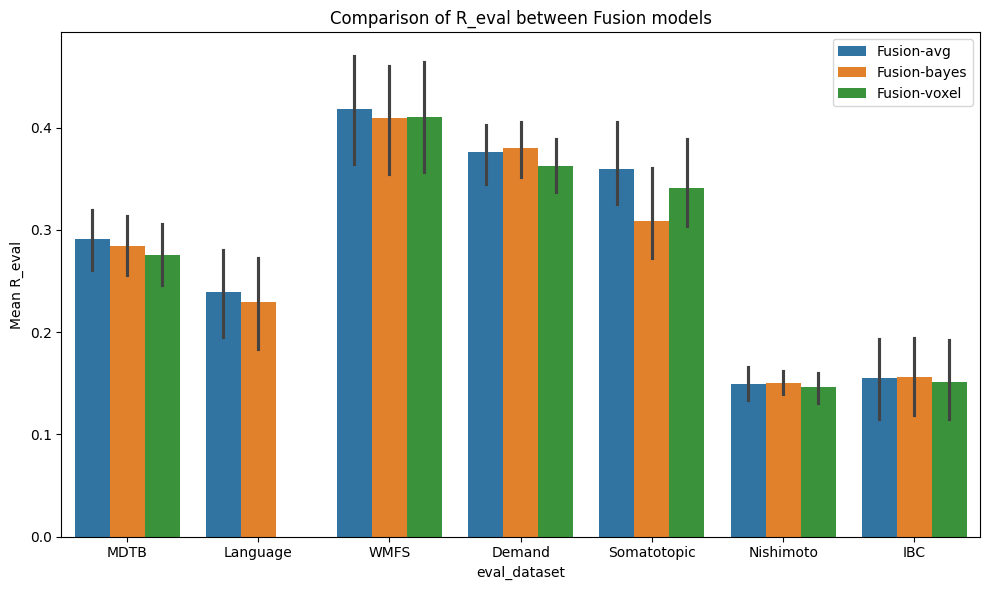

In [7]:
# Plot the results
plt.figure(figsize=(10, 6))
x = range(len(dataset_list))
sns.barplot(data=pd.concat([df_fuse_avg, df_fuse_bayes, df_fuse_voxel]), x='eval_dataset', y='R_eval', hue='train_dataset')
plt.ylabel('Mean R_eval')
plt.title('Comparison of R_eval between Fusion models')
plt.legend()
plt.tight_layout()
plt.show()